In [1]:
#import packages
from pyhmc import hmc
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
#source: https://towardsdatascience.com/python-hamiltonian-monte-carlo-from-scratch-955dba96a42d
#functions for hamiltonian monte carlo
def normal(x, mu, sigma):
    numerator = np.exp(-1*((x - mu)**2)/(2*sigma**2))
    denominator = sigma*np.sqrt(2*np.pi)
    return numerator/denominator

def neg_log_prob(x, mu, sigma):
    prob = np.log(normal(x=x, mu=mu, sigma=sigma))
    grad = -1*(x-mu)/(sigma**2)
    return prob, grad

In [3]:
#parameters for normal distribution
x = np.random.randn(1)
mu = 0.0
sigma = 1.0
#hamiltonian monte carlo with default tuning parameters
sample = hmc(fun=neg_log_prob, x0=x, args=(mu, sigma,), n_samples=5000, n_burn=1000)

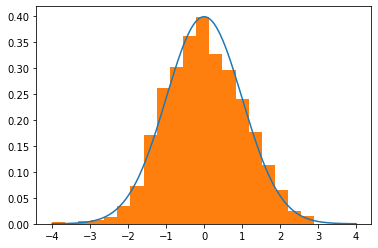

In [4]:
#graph sampling distribution vs normal distribution
lines = np.linspace(-4, 4, 10_000)
normal_curve = [normal(x=l,mu=mu, sigma=sigma) for l in lines]
plt.plot(lines, normal_curve)
plt.hist(sample, density=True, bins=20)
plt.show()

In [9]:
#source: https://arxiv.org/pdf/1302.6182.pdf (research paper)
#functions for adaptive hamiltonian monte carlo
def k_function(gamma_i, gamma_j):
    return np.exp(-0.5*gamma_i.T@inv_sigma@gamma_j).item(0)

def K_matrix(prev_gammas):
    K_mat = np.zeros(shape=(len(prev_gammas), len(prev_gammas)))
    for m in range(len(prev_gammas)):
        row_list = list()
        for n in range(len(prev_gammas)):
            k = k_function(np.array(prev_gammas[m]), np.array(prev_gammas[n]))
            row_list.append(k)
        K_mat[m] = np.array(row_list)
    return K_mat

def k_vector(K_mat):
    return K_mat[-1].T

def f_function(gamma_i):
    return np.random.normal(0, k_function(np.array(gamma_i), np.array(gamma_i)), 1).item(0)

def e_function(sigma_eta):
    return np.random.normal(0, sigma_eta, 1).item(0)

def r_function(gamma_i, sigma_eta):
    return f_function(gamma_i) + e_function(sigma_eta)

def mu_function(gamma_i, s, sigma_eta, K_mat, k_vect, r_vect):
    return (k_vect.T @ np.linalg.inv(K_mat + sigma_eta*np.identity(K_mat.shape[0])) @ r_vect*s).item(0)

def sigma_function(gamma_i, sigma_eta, K_mat, k_vect):
    return abs((k_function(np.array(gamma_i), np.array(gamma_i)) - (k_vect.T @ np.linalg.inv(K_mat + sigma_eta*np.identity(K_mat.shape[0])) @ k_vect)).item(0))

def beta_function(i):
    return 2*np.log(((i + 1)**3*(np.pi**2))/0.3)

def acquisition(gamma_i, s, sigma_eta, K_mat, k_vect, r_vect, i, p):
    return mu_function(np.array(gamma_i), s, sigma_eta, K_mat, k_vect, r_vect) + p*np.sqrt(sigma_function(np.array(gamma_i), sigma_eta, K_mat, k_vect))*np.sqrt(beta_function(i))


In [ ]:
from itertools import product
#parameters for adaptive algorithm
step_sizes = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21] #set of all step sizes = E
num_steps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110] #set of all num of steps = L
gammas = list(product(step_sizes, num_steps)) #set of all gammas = E x L
random.shuffle(gammas) #random order of gammas
sigma_matrix = np.matrix([[0.0016, 0], [0, 400]]) #sigma matrix
inv_sigma = np.linalg.inv(sigma_matrix) #sigma matrix inverse
alpha = 4 #paper defines this
w = 100 #paper defines this
m = 10 #burnin/w = 1000/100

#parameters for normal distribution
mu = 0.0
sigma = 1.0
r_vect = np.array([]) #vector of r_vals
prev_gammas = np.array([]) #vector of gammas
gamma = gammas[0] #set gamma to first gamma
for g in range(len(gammas)):
    #find the K matrix and k vector for this iteration
    if g == 0:
        prev_gammas = np.append(prev_gammas, np.array(gamma))
        K_mat = np.matrix([k_function(np.array(gamma), np.array(gamma))])
    else:
        prev_gammas = np.vstack([prev_gammas, gamma])
        K_mat = K_matrix(prev_gammas)
    k_vect = k_vector(K_mat)    
    sample_means = list()
    #run hamiltonian monte carlo for m iterations
    for n in range(m):
        x = np.random.randn(1)
        step_size = gamma[0]
        num_steps = gamma[1]
        sample = hmc(fun=neg_log_prob, x0=x, args=(mu, sigma,), n_samples=5000, n_burn=1000, n_steps=num_steps, epsilon=step_size)
        sample_means.append(np.mean(sample))
    sigma_eta = np.std(sample_means)**2 #sigma_eta squared
    r_val = r_function(np.array(gamma), sigma_eta) #r_val
    #change s only if it meets conditions
    if g == 0:
        s = alpha/r_val
    elif r_val > np.amax(r_vect):
        s = alpha/r_val
    r_vect = np.append(r_vect, np.array(r_val)) #add r_val to r_vect
    u = np.random.uniform(0.0, 1.0) #sample from uniform distribution
    p = 1/np.sqrt(max(g-w+2, 1))
    #change gamma only if it meets condition
    if u < p:
        #find the gamma that maximizes the acquisition function
        func_vals = [acquisition(np.array(x), s, sigma_eta, K_mat, k_vect, r_vect, g+1, p) for x in gammas]
        fmax = max(func_vals)
        gamma = gammas[func_vals.index(fmax)]
    

In [11]:
#optimal gamma value
gamma

(0.21, 110)

In [12]:
step_size = gamma[0]
num_steps = gamma[1]
#hamiltonian monte carlo with optimized tuning parameters
sample = hmc(fun=neg_log_prob, x0=x, args=(mu, sigma,), n_samples=5000, n_burn=1000, n_steps=num_steps, epsilon=step_size)

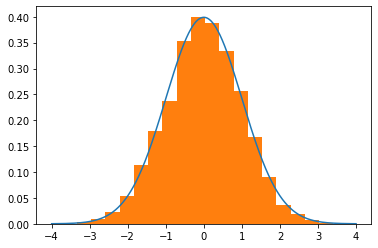

In [13]:
#graph sampling distribution vs normal distribution
lines = np.linspace(-4, 4, 10_000)
normal_curve = [normal(x=l,mu=mu, sigma=sigma) for l in lines]
plt.plot(lines, normal_curve)
plt.hist(sample, density=True, bins=20)
plt.show()